In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.datasets import cifar10

import warnings
warnings.filterwarnings("ignore")

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

print(X_train.shape)  # (50000, 32, 32, 3)
print(y_train.shape)  # (50000,)

# Rendo ogni immagine un vettore
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Uso solo 10000 immagini invece di 50,000
X_train_reduced = X_train[:10000]
y_train_reduced = y_train[:10000]

X_test_reduced = X_test[:2000]
y_test_reduced = y_test[:2000]

# standardizzazione
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_reduced)
X_test_std = scaler.transform(X_test_reduced)

2025-05-02 11:46:39.833579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746186400.078962      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746186400.153539      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(50000, 32, 32, 3)
(50000,)


In [2]:
def grid_search (X_train, y_train, params, model):
    grid_search = GridSearchCV(model, params, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)
    best_conf = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    model_trained = grid_search.best_estimator_
    return best_conf, best_accuracy, model_trained


In [3]:
# Dizionario dei modelli con i rispettivi parametri
modelli_parametri = {
    "SVM": (SVC(), {'C': [0.1, 1], 'kernel': ['linear', 'rbf']}),
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10], 'solver': ['lbfgs']}),
    "KNN": (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}),
    "Decision Tree": (DecisionTreeClassifier(random_state=42), {'max_depth': [5, 7], 'criterion': ['entropy']})
}

risultati = {}

# Eseguo grid search per ciascun modello
for nome, (modello, parametri) in modelli_parametri.items():
    print(f"\n Allenamento: {nome}")
    best_conf, best_acc, best_model = grid_search(X_train_std, y_train_reduced, parametri, modello)
    risultati[nome] = {
        'configurazione': best_conf,
        'accuracy_validation': best_acc,
        'modello': best_model
    }
    print(f"Best config: {best_conf}")
    print(f"Accuracy (cross-val): {best_acc:.4f}")


 Allenamento: SVM
Best config: {'C': 1, 'kernel': 'rbf'}
Accuracy (cross-val): 0.4672

 Allenamento: Logistic Regression
Best config: {'C': 0.1, 'solver': 'lbfgs'}
Accuracy (cross-val): 0.3139

 Allenamento: KNN
Best config: {'n_neighbors': 7, 'weights': 'distance'}
Accuracy (cross-val): 0.3055

 Allenamento: Decision Tree
Best config: {'criterion': 'entropy', 'max_depth': 7}
Accuracy (cross-val): 0.2539


In [4]:
# Seleziono il modello con la migliore accuracy di validazione
best_name = max(risultati, key=lambda k: risultati[k]['accuracy_validation'])
best_model = risultati[best_name]['modello']
best_accuracy = risultati[best_name]['accuracy_validation']

print(f"\n Miglior modello: {best_name} con accuracy {best_accuracy:.4f}")


 Miglior modello: SVM con accuracy 0.4672


In [5]:
#Calcolo delle prestazioni su test set
def prestazioni (modello, X_test, y_test):
    y_predicted = modello.predict(X_test)
    conf_matrix_test = confusion_matrix(y_test, y_predicted)

    accuracy_test = accuracy_score(y_test, y_predicted)
    precision_test = precision_score(y_test, y_predicted, average='weighted', zero_division=0)
    recall_test = recall_score(y_test, y_predicted, average='weighted', zero_division=0)
    f1_test = f1_score(y_test, y_predicted, average='weighted', zero_division=0)

    # Report dettagliato per classe 
    report = classification_report(y_test, y_predicted, zero_division=0)

    print("Matrice di confusione:\n", conf_matrix_test)
    print(f"\nAccuracy:  {accuracy_test:.4f}")
    print(f"Precision: {precision_test:.4f}")
    print(f"Recall:    {recall_test:.4f}")
    print(f"F1 Score:  {f1_test:.4f}")
    print("\nReport dettagliato per classe:\n", report)

    return {
        "accuracy": accuracy_test,
        "precision": precision_test,
        "recall": recall_test,
        "f1_score": f1_test,
        "confusion_matrix": conf_matrix_test,
        "report": report
    }

metriche_test = prestazioni(best_model, X_test_std, y_test_reduced)

Matrice di confusione:
 [[105   4   7   5   8   2   7   7  36  15]
 [  6 108   3   8   2   5   6   7  16  37]
 [ 26   5  62  15  32   9  24  14   4   4]
 [ 10   5  21  63  10  31  28  13   5  13]
 [  9   4  43  13  63   5  32  14  13   2]
 [  2   5  19  38  21  59  23   9   5   4]
 [  2   5  19  17  22   8 128   4   8   3]
 [  6   9  12  13  17  17   9  95   6   9]
 [ 18  14   3   3   5   6   2   6 148  12]
 [ 10  33   2   8   3   5   9   7  22 104]]

Accuracy:  0.4675
Precision: 0.4626
Recall:    0.4675
F1 Score:  0.4631

Report dettagliato per classe:
               precision    recall  f1-score   support

           0       0.54      0.54      0.54       196
           1       0.56      0.55      0.55       198
           2       0.32      0.32      0.32       195
           3       0.34      0.32      0.33       199
           4       0.34      0.32      0.33       198
           5       0.40      0.32      0.36       185
           6       0.48      0.59      0.53       216
      

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix_multiclass(cm):
# Calcola dinamicamente le etichette delle classi
    class_labels = [f"Class {i}" for i in range(cm.shape[0])]
    
    # Visualizza la heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

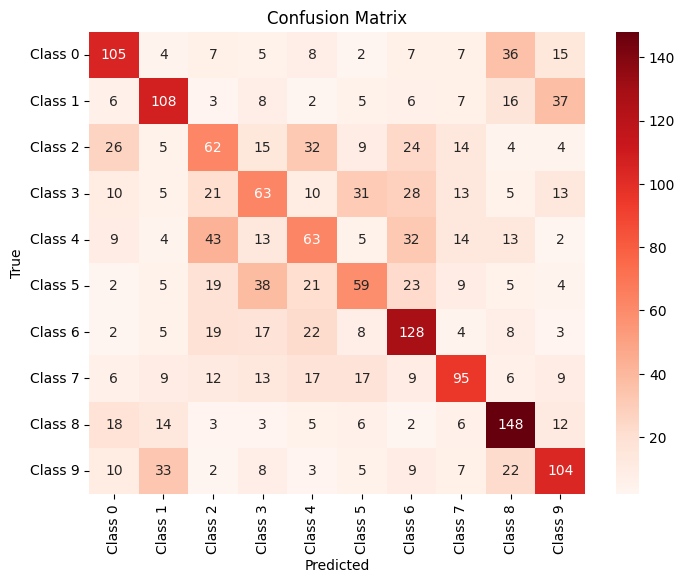

In [7]:
#visualizzazione matrice di confusione
plot_confusion_matrix_multiclass(metriche_test ["confusion_matrix"])